For this project we are anaylzing the dataset of Gett, a Ground Transportation Management technology platform.  
Clients order taxis and the system matches them with an available driver. In this dataset only rides that did not complete successfully are displayed.   
Our task is to uncover some trends in these failed orders.

## Data Description

We have the dataset *data_orders* being stored in a CSV format.<br>The data_orders data set contains the following columns:  
- *order_datetime* : time of the order
- *origin_longitude* : longitude of the order
- *origin_latitude* : latitude of the order
- *m_order_eta* : time before order arrival
- *order_gk* : order number
- *order_status_key* : status, an enumeration consisting of the following mapping:
  - 4 : cancelled by client,
  - 9 : cancelled by system, i.e., a reject
- *is_driver_assigned_key* : whether a driver has been assigned
- *cancellation_time_in_seconds* : how many seconds passed before cancellation

## Loading and Initial Exploration

As a first step we will import the needed libraries. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from h3 import h3
import folium

Then let's load the CSV file into a Pandas Dataframe and look at it.

In [2]:
df_orders = pd.read_csv(r'C:\Users\arnau\Gett_project\data\data_orders.csv')

df_orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [3]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


The dataframe looks well formatted. We can already see that in the m_order_eta and cancellations_time_in_seconds columns have missing values. So let's have a look at what other columns have missing values and how many are there.

In [4]:
df_orders.isna().sum()

order_datetime                      0
origin_longitude                    0
origin_latitude                     0
m_order_eta                      7902
order_gk                            0
order_status_key                    0
is_driver_assigned_key              0
cancellations_time_in_seconds    3409
dtype: int64

We see that only these two columns (*m_order_eta*, *cancellations_time_in_seconds*) have missing values. Next step we will look more into detail why these columns have missing values.

## Missing Values Investigation


### Hypothesis
From the Data Description we know that we have two types of cancellations, by the customer and by the system. <br>So it would be interesting to know if for the orders cancelled by the system have an actual value in the *cancellations_time_in_seconds* column. 
<br>Moreover, we can see that the *is_driver_assigned_key* column gives us the information about if the cancelled order had an assigned driver. Maybe the cancelled orders that didn't have an assigned driver didn't have a value for the Estimated Time to Arrival, let's investigate. 


### Analysis

1. Missing values in cancellations_time_in_seconds

In [5]:
customer_cancelled_df = df_orders[df_orders['order_status_key'] == 4].copy()

system_cancelled_df = df_orders[df_orders['order_status_key'] == 9].copy()

In [6]:
number_system_cancelled = system_cancelled_df.shape[0]
missing_values_cancellations_column = system_cancelled_df.isna().sum()['cancellations_time_in_seconds']

In [7]:
print(f'The number of system cancelled orders are {number_system_cancelled}', 
      f'\nwhich corresponds to the missing values in the cancellations_time_in_seconds column ({missing_values_cancellations_column}).')

The number of system cancelled orders are 3409 
which corresponds to the missing values in the cancellations_time_in_seconds column (3409).


We see clearly that the orders cancelled by the system don't have any value for cancellation time, which makes sense as when the system rejected the order it is supposed to be instantely.
<br>Additionally, this information is only interesting to understand customer behaviour not the systems behaviour.

2. Missing values in *m_orders_eta*

In [8]:
driver_assigned_df = df_orders[df_orders['is_driver_assigned_key'] == 1].copy()
no_driver_assigned_df = df_orders[df_orders['is_driver_assigned_key'] == 0].copy()

In [9]:
num_orders_wo_driver = no_driver_assigned_df.shape[0]
missing_values_eta = no_driver_assigned_df.isna().sum()['m_order_eta']

In [10]:
print(f'The number of cancelled orders without assigned driver is: {num_orders_wo_driver}'
      f'\ncorresponds to the number of missing values in the eta column ({missing_values_eta}).')

The number of cancelled orders without assigned driver is: 7902
corresponds to the number of missing values in the eta column (7902).


From this analysis we now know that the missing values in the m_order_eta column are due to the order not having an assigned driver. This is logical as if the system was still looking for a driver it could not predict how long it would take for the client to arrive at its destination. 

### Conclusion

With our analysis we now know that the missing values are legitimate and make sense in the business context. <br>Therefore, we don't need to make specific adjustments or replace these missing values. 

## EDA

Let's now visualize this dataset to better understand some trends.  
We'll first visualize the distribution of cancelled orders according to reasons for failure:
1. Before and After driver Assignment
2. Customer or System Rejection

Then we will plot the distribution of failed orders by hour to see if there are certain hours that are subject to higher amount of cancellations.

3. Failed order by hour
4. Average cancellation time by hour
5. Average ETA by hour

Lastly we'd like to understand if some regions have a higher proportion of failed orders. For this we'll use the h3 and folium libraries.

6. Choropleth of failed orders by region (hexagons)

### 1. Before and After driver Assignment

Before making the graph we will modify the encoding for customer and system cancelled orders to make it easier to plot.  
We will change the 4 and 9 in the order_status_key column to 0 (Customer cancelled) and 1 (system cancelled). 

In [11]:
df_orders.replace({'order_status_key': {4:0, 9:1}}, inplace=True)

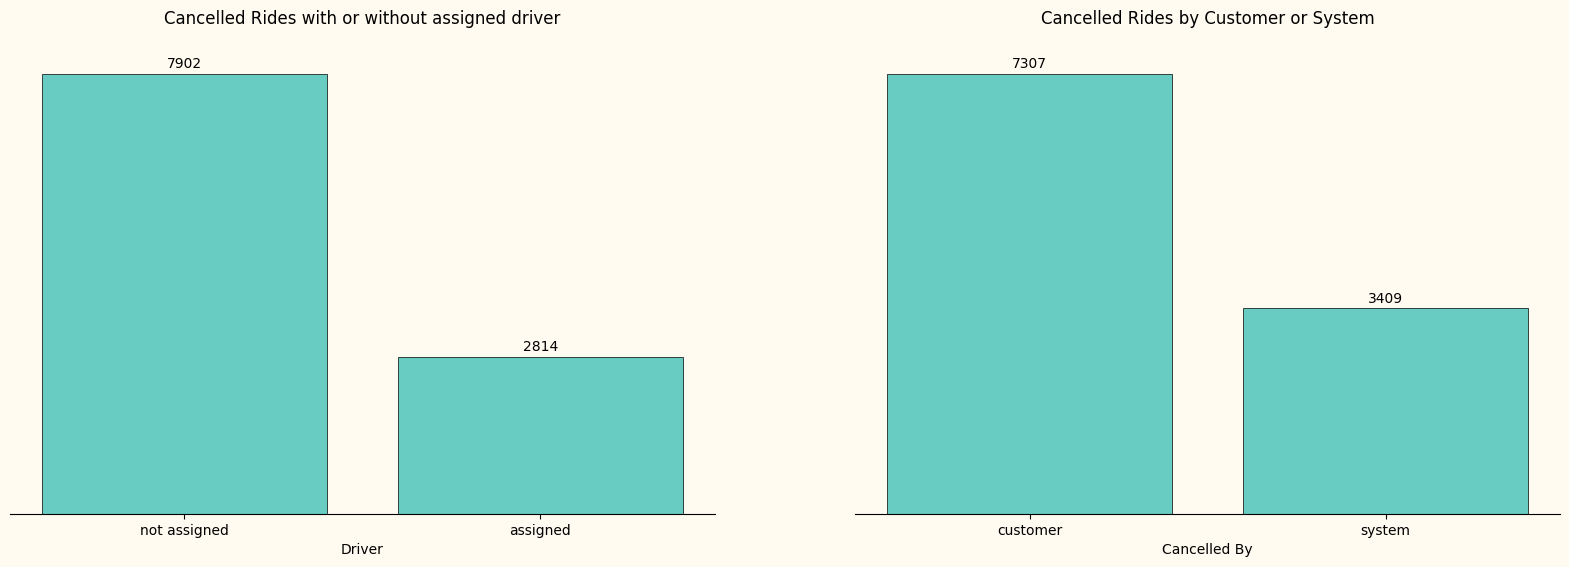

In [12]:
# Let first define the size of our graphing area
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))

# ax1

# Firstly  we plot a Histogram of the failed orders, passing the is_driver_assigned_key as the x-value 

sns.histplot(data=df_orders, x='is_driver_assigned_key', discrete=True, shrink=.8, linewidth = 0.5, ax=ax1, color='#37BDB5')

# Then we set the title of the first graph

ax1.set_title('Cancelled Rides with or without assigned driver',pad=20)


# To simplify the graph and only keep crucial information we'll get rid of the y-axis. 

sns.despine(left=True, ax=ax1)

# We first set the x-axis ticks to 0 and 1 and rename them  to 'not assigned' and 'assigned'.

ax1.set_xticks([0,1])
ax1.set_xticklabels(['not assigned', 'assigned'])
ax1.set(xlabel='Driver')

# And then get rid of the y-axis ticks and label.
ax1.set_yticklabels([])
ax1.tick_params(left=False)
ax1.set(ylabel=None)

# Finally, as we got rid of the y-axis and don't have a good understanding of the scale we'll add the actual values of the two bars to the chart
ax1.bar_label(ax1.containers[0], padding=2)

#ax2
# Secondly we plot a Histogram of the failed orders, passing the order_status_key as the x-value 

sns.histplot(data=df_orders, x='order_status_key', discrete=True, shrink=.8, linewidth = 0.5, ax=ax2, color='#37BDB5')


# Then we set the title of the second graph


ax2.set_title('Cancelled Rides by Customer or System',pad=20)


# To simplify the graph and only keep crucial information we'll get rid of the y-axis. 

sns.despine(left=True,  ax=ax2)

# We first set the x-axis ticks to 0 and 1 and rename them  to 'customer' and 'system'.

ax2.set_xticks([0,1])
ax2.set_xticklabels(['customer', 'system'])
ax2.set(xlabel='Cancelled By')

# And then get rid of the y-axis ticks and label
ax2.set_yticklabels([])
ax2.tick_params(left=False)
ax2.set(ylabel=None)

# Finally, as we got rid of the y-axis and don't have a good understanding of the scale we'll add the actual values of the two bars to the chart
ax2.bar_label(ax2.containers[0], padding=2)


fig.set_facecolor('#FFFBF0')
ax1.set_facecolor('#FFFBF0')
ax2.set_facecolor('#FFFBF0');



### Conclusions

From these graphs we can see that a majority of rides are being cancelled before a driver has been assigned, which could mean:
- that the system took too long to assign a driver 
- there were too few drivers available to accept a ride
- available drivers didn't accept the ride quickly

<br> Moreover, we see that the majority of rides were cancelled by the customers and not rejected by the system.
This could indicate that the system is working reasonably well and the main reason for cancellations stems from customers. 
However, the relatively high amount of system rejections (**~32%**) might indicate some issues in the system. 

### 3. Distribution of Cancelled Orders by Hour

Now that we have some ideas about the reasons of cancellations let's have a look at the distribution by hour. Are there any hour that sees a higher number of cancellations?

In [13]:
df_orders['Hour'] = pd.to_datetime(df_orders['order_datetime'], format= '%H:%M:%S').dt.hour

driver_assigned_df['Hour'] = df_orders['Hour']
no_driver_assigned_df['Hour'] = df_orders['Hour']

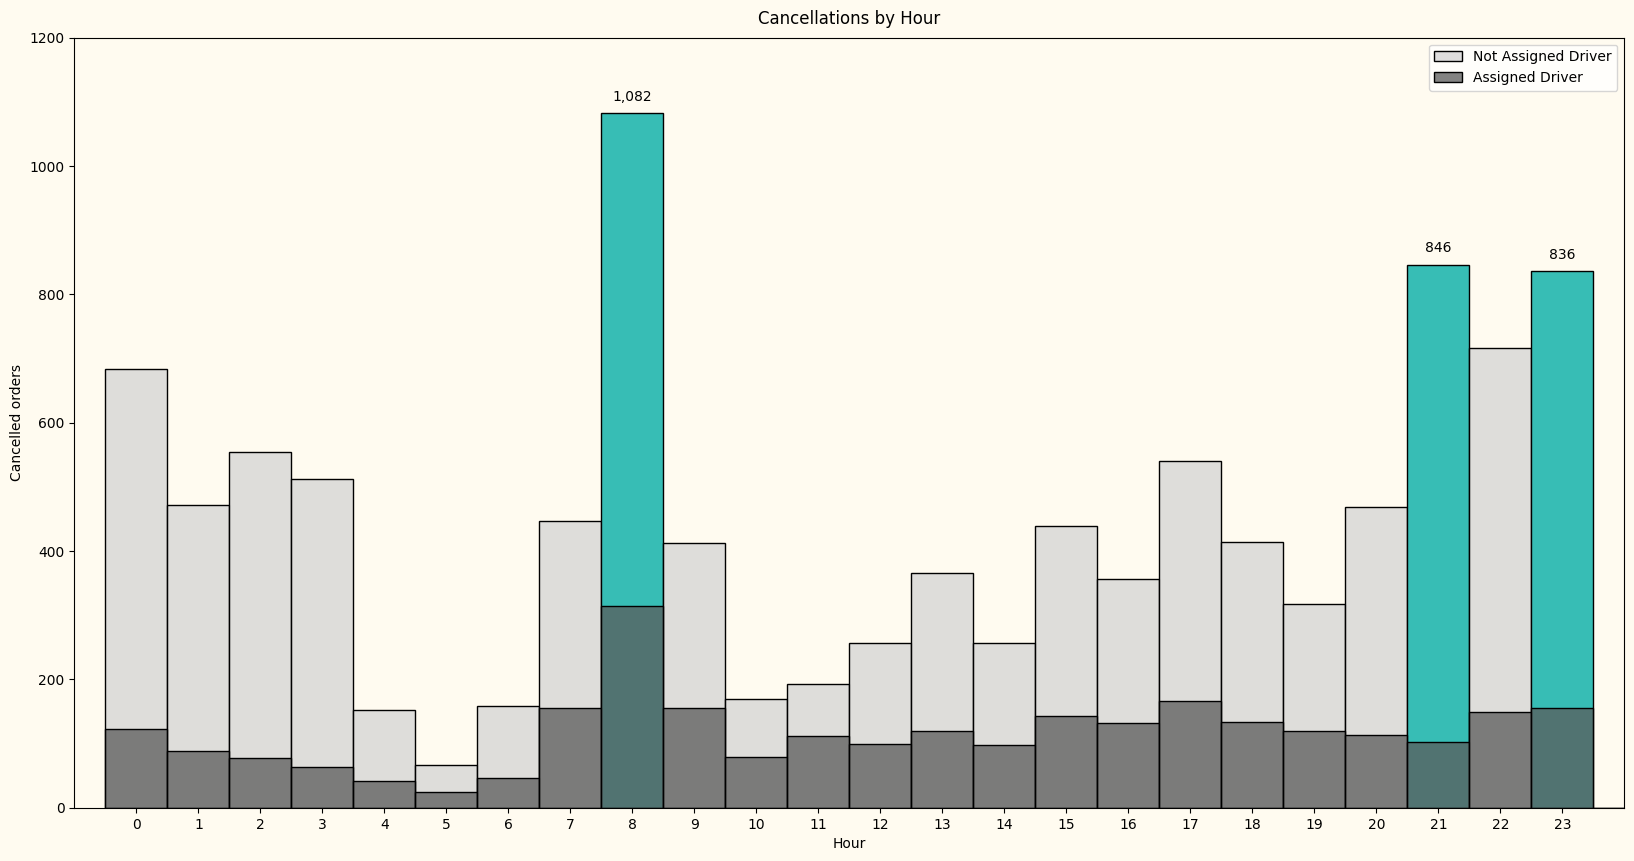

In [14]:
# Let's define the space in which we will draw our graph along with the title.
# As we only want to see 24 hours we set the limit of the x axis to 24, and for the y-axis we set the maximum limit to 1200
# Lastly we rename the y-axis label to make it understandable that we are plotting the cancelled orders


fig, ax1 = plt.subplots(1, 1, figsize=(20,10))

#plt.figure(figsize=(20,10))
plt.title('Cancellations by Hour', pad=10)
plt.xlim(-1,24)
plt.xticks(range(0,24))
plt.ylim(0,1200)
plt.ylabel('Cancelled orders')


# We start by plotting the total numober of cancelled orders by hours
# and then add another plot on top to show the proportion of cancelled orders that had an assigned driver
# Lastly to make our plot more readable we add a legend to it.

ax = sns.histplot(data=df_orders, x='Hour', binrange=(0,24), binwidth=1, discrete=True, color='#D3D3D3')

sns.histplot(data=driver_assigned_df, x='Hour', binrange=(0,24), binwidth=1, discrete=True, color='#5A5A5A')

plt.legend(labels=['Not Assigned Driver', 'Assigned Driver'])

# As this plot doesn't highlight anything in particular we want to make the top 3 hours with the most cancellation stand out.
# Therefore we first get a list of heights from our plot and assigning it to a 'heights' list.
# Then we get the height of the hour with the 3rd most cancellation and assign it to the variable 'third_highest'.
# Using an if statement we check if the ax.patches height is higher or equal to this height and if True set a determined facecolor.
# Lastly, we want to see exactly how many orders were cancelled in these three hours so we use the plt.text method to add it to the graph.

heights = [p.get_height() for p in ax.patches]
third_highest = sorted(heights)[-3]
for p in ax.patches:
    if  p.get_height() >= third_highest:
        p.set_facecolor('#37BDB5')
        plt.text(x=p.get_x()+0.5, y=p.get_height() + 20, s= '{:,}'.format(p.get_height()), ha='center')


# To change slightly the color of the background of the plot we change it to this warmer color

ax.set_facecolor('#FFFBF0')
fig.set_facecolor('#FFFBF0')
plt.show()

We see that there is a huge peak at 8am and then two smaller peaks in the evening at 9 and 11pm. 
<br>This peak could be explained by the morning traffic and some higher traffic during the evening. 
<br>We also see that cancelled rides without an assigned driver are consistently higher than rides that had an assigned driver. <br>This makes us think that there are not enough drivers to satisfy all the demand.

### 4. Average time to cancellation

We can dive a bit further into the analysis by looking at the average time it takes customers to cancel, deeing that there is a difference in volume of cancellation with and without assigned driver we would like to see if that is also reflected in the time it takes customers to cancel. 
<br>Are customers cancelling faster when there is no driver assigned?

Before we look at this we need to see the distribution of the data we have in the column *cancellations_time_in_seconds*:

<br>- First we'll have a look at the numbers and then visualize the distribution using a histogram and boxplot
<br>- If we can see any outliers we'll remove them
<br>- Finally we will plot the average time to cancellation by hour

> **Recap of our previous findings**. 
<br>The column *cancellations_time_in_seconds* has 3,409 missing values due to the system rejecting the order. <br>Therefore, we will first drop the rows of the dataframes *driver_assigned_df* and *no_driver_assigned_df* where the system rejected the order (i.e. order_status_key = 9).

In [15]:
print(driver_assigned_df.shape)
print(no_driver_assigned_df.shape)

(2814, 9)
(7902, 9)


In [16]:
driver_assigned_df.drop(driver_assigned_df[driver_assigned_df['order_status_key'] == 9].index, inplace=True)
no_driver_assigned_df.drop(no_driver_assigned_df[no_driver_assigned_df['order_status_key'] == 9].index, inplace=True)

In [17]:
print(driver_assigned_df.shape)
print(no_driver_assigned_df.shape)

(2811, 9)
(4496, 9)


In [18]:
print(driver_assigned_df.isna().sum())
print(no_driver_assigned_df.isna().sum())

order_datetime                   0
origin_longitude                 0
origin_latitude                  0
m_order_eta                      0
order_gk                         0
order_status_key                 0
is_driver_assigned_key           0
cancellations_time_in_seconds    0
Hour                             0
dtype: int64
order_datetime                      0
origin_longitude                    0
origin_latitude                     0
m_order_eta                      4496
order_gk                            0
order_status_key                    0
is_driver_assigned_key              0
cancellations_time_in_seconds       0
Hour                                0
dtype: int64


We can see that there is no missing value in the first dataframe and some missing values in the second. As it's in a column that's not of interest for this analysis we can go ahead and analyze more in detail the *cancellations_time_in_seconds* column of both dataframes.

In [19]:
print(driver_assigned_df.describe()['cancellations_time_in_seconds'])
print(no_driver_assigned_df.describe()['cancellations_time_in_seconds'])

count    2811.000000
mean      233.897901
std       292.709718
min         6.000000
25%        54.000000
50%       127.000000
75%       296.000000
max      4303.000000
Name: cancellations_time_in_seconds, dtype: float64
count    4496.000000
mean      110.371441
std       120.676021
min         3.000000
25%        38.000000
50%        88.000000
75%       157.000000
max      4097.000000
Name: cancellations_time_in_seconds, dtype: float64


We can see that when a driver is assigned the average and median time to cancellations is higher than when there is no driver assigned. 

#### Histogram and Boxplot

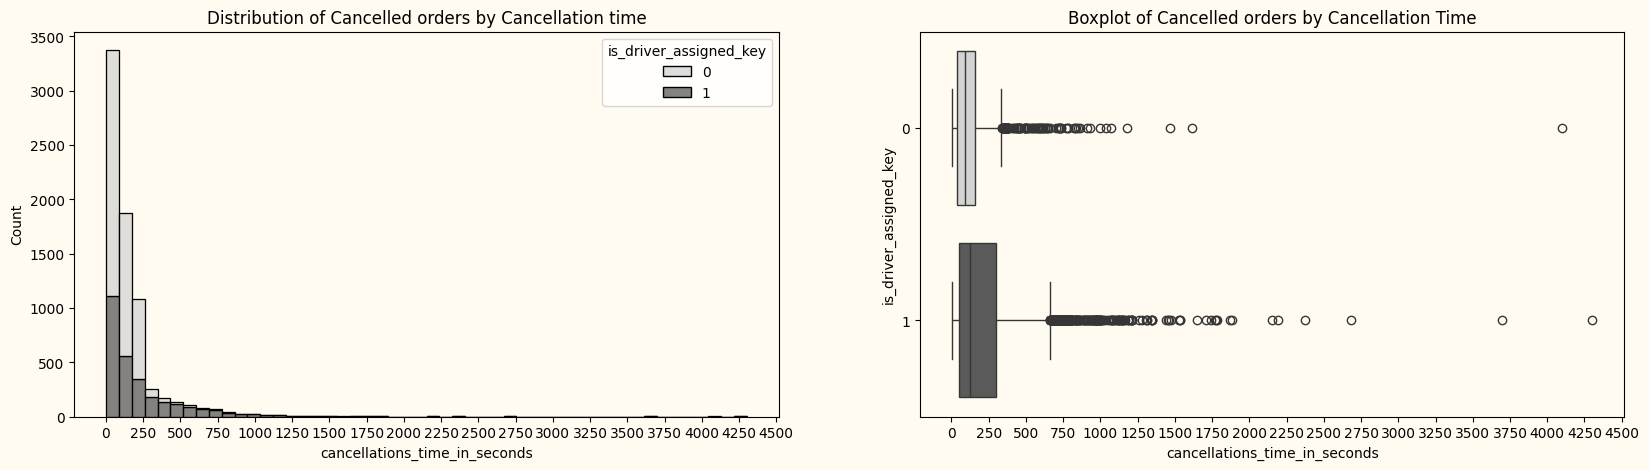

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
ax1.set_title('Distribution of Cancelled orders by Cancellation time')
ax2.set_title('Boxplot of Cancelled orders by Cancellation Time')
ax1.set_xticks(np.arange(0,5000,250))
ax2.set_xticks(np.arange(0,5000,250))
sns.histplot(data=df_orders, x='cancellations_time_in_seconds', bins=50, hue='is_driver_assigned_key', multiple='stack', ax=ax1, palette=['#D3D3D3','#5A5A5A'])
sns.boxplot(data=df_orders, x='cancellations_time_in_seconds', y='is_driver_assigned_key', hue='is_driver_assigned_key', legend=False, orient='h', ax=ax2, palette=['#D3D3D3','#5A5A5A'])
fig.set_facecolor('#FFFBF0')
ax1.set_facecolor('#FFFBF0')
ax2.set_facecolor('#FFFBF0');

From these two graphs we can see that the majority of orders are cancelled between 0 and 250s. 
<br>Moreover, orders that don't have an assigned driver are cancelled before 250s are over, with a drastic drop after 250s. 
<br>meaning that customers are faster in cancelling a ride when no driver is assigned, whereas when a driver is assigned more are willing to wait. 
<br>This also shown in the Boxplot where we see that the mean cancellation time is higher but also the distribution of cancellation times is larger when there is a driver assigned. 


<br>The Boxplot shows us that for both rides, with or without an assigned driver, there are quite some outliers. 
<br>To keep our focus on the majority of cases we will only consider cancelled rides that fall in between 1.5 * Inter Quantile Range from the lower (25%) and upper limit (75%). 

In [21]:
print(driver_assigned_df.shape)
print(no_driver_assigned_df.shape)

(2811, 9)
(4496, 9)


In [22]:
IQR_driver_assigned = 296 - 54
IQR_no_driver_assigned = 157 - 38

driver_assigned_upper_fence = 296+(1.5*IQR_driver_assigned)
no_driver_assigned_upper_fence = 157+(1.5*IQR_no_driver_assigned)

print(driver_assigned_upper_fence, no_driver_assigned_upper_fence)

659.0 335.5


In [23]:
driver_assigned_df_wo_outlier = driver_assigned_df.drop(driver_assigned_df[driver_assigned_df['cancellations_time_in_seconds'] > driver_assigned_upper_fence].index)
no_driver_assigned_df_wo_outlier = no_driver_assigned_df.drop(no_driver_assigned_df[no_driver_assigned_df['cancellations_time_in_seconds'] > no_driver_assigned_upper_fence].index)

In [24]:
print(driver_assigned_df_wo_outlier.shape)
print(no_driver_assigned_df_wo_outlier.shape)

(2592, 9)
(4395, 9)


In [25]:
driver_assigned_df_wo_outlier.describe()

,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,Hour
count,2592.000000,2592.000000,2592.000000,2.592000e+03,2592.0,2592.0,2592.000000,2592.000000
mean,-0.962896,51.450290,440.674383,3.000594e+12,4.0,1.0,170.244599,12.536265
std,0.019514,0.010893,290.068530,2.546720e+07,0.0,0.0,157.882988,6.599375
min,-1.060767,51.400069,60.000000,3.000550e+12,4.0,1.0,6.000000,0.000000
25%,-0.973433,51.444904,179.000000,3.000579e+12,4.0,1.0,50.000000,8.000000
50%,-0.966260,51.452086,359.000000,3.000592e+12,4.0,1.0,110.000000,13.000000
75%,-0.950018,51.456173,656.000000,3.000623e+12,4.0,1.0,238.000000,18.000000
max,-0.876873,51.494748,1559.000000,3.000633e+12,4.0,1.0,659.000000,23.000000


In [26]:
no_driver_assigned_df_wo_outlier.describe()

,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,Hour
count,4395.000000,4395.000000,0.0,4.395000e+03,4395.0,4395.0,4395.000000,4395.000000
mean,-0.964686,51.450830,NaN,3.000599e+12,4.0,0.0,99.261661,12.706485
std,0.022503,0.011777,NaN,2.340489e+07,0.0,0.0,72.859466,7.876657
min,-1.066952,51.399523,NaN,3.000550e+12,4.0,0.0,3.000000,0.000000
25%,-0.974195,51.444830,NaN,3.000584e+12,4.0,0.0,37.000000,7.000000
50%,-0.967002,51.452523,NaN,3.000595e+12,4.0,0.0,85.000000,14.000000
75%,-0.950065,51.456835,NaN,3.000624e+12,4.0,0.0,151.000000,21.000000
max,-0.867088,51.496169,NaN,3.000632e+12,4.0,0.0,334.000000,23.000000


In [27]:
df_user_cancelled_no_outlier = pd.concat([driver_assigned_df_wo_outlier, no_driver_assigned_df_wo_outlier])

df_user_cancelled_no_outlier.shape

(6987, 9)

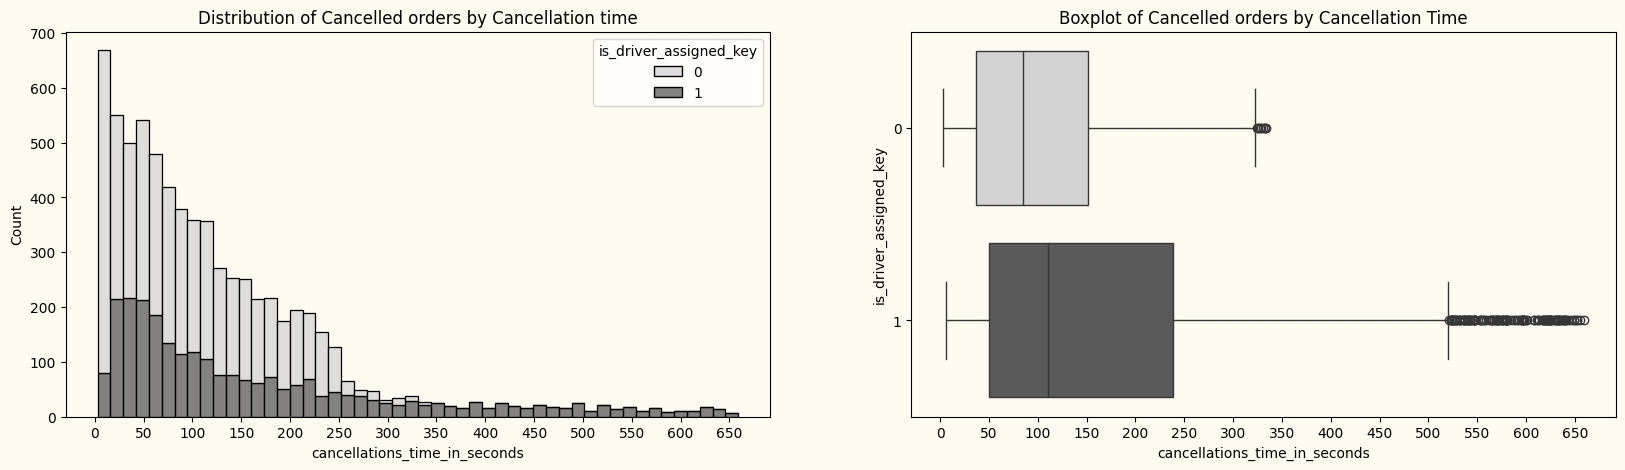

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
ax1.set_title('Distribution of Cancelled orders by Cancellation time')
ax2.set_title('Boxplot of Cancelled orders by Cancellation Time')
ax1.set_xticks(np.arange(0,1000,50))
ax2.set_xticks(np.arange(0,1000,50))
sns.histplot(data=df_user_cancelled_no_outlier, x='cancellations_time_in_seconds', bins=50, hue='is_driver_assigned_key', multiple='stack', ax=ax1, palette=['#D3D3D3','#5A5A5A'])
sns.boxplot(data=df_user_cancelled_no_outlier, x='cancellations_time_in_seconds', y='is_driver_assigned_key', hue='is_driver_assigned_key', legend=False, orient='h',whis=1.5, ax=ax2, palette=['#D3D3D3','#5A5A5A'])
fig.set_facecolor('#FFFBF0')
ax1.set_facecolor('#FFFBF0')
ax2.set_facecolor('#FFFBF0');

We can see that most orders that did not have an assigned driver were cancelled before ~2min30s (151s), while users waited comparatively longer when a driver was assigned, most orders being cancelled within ~4min (240s).

Let's have a look at the hourly distribution.

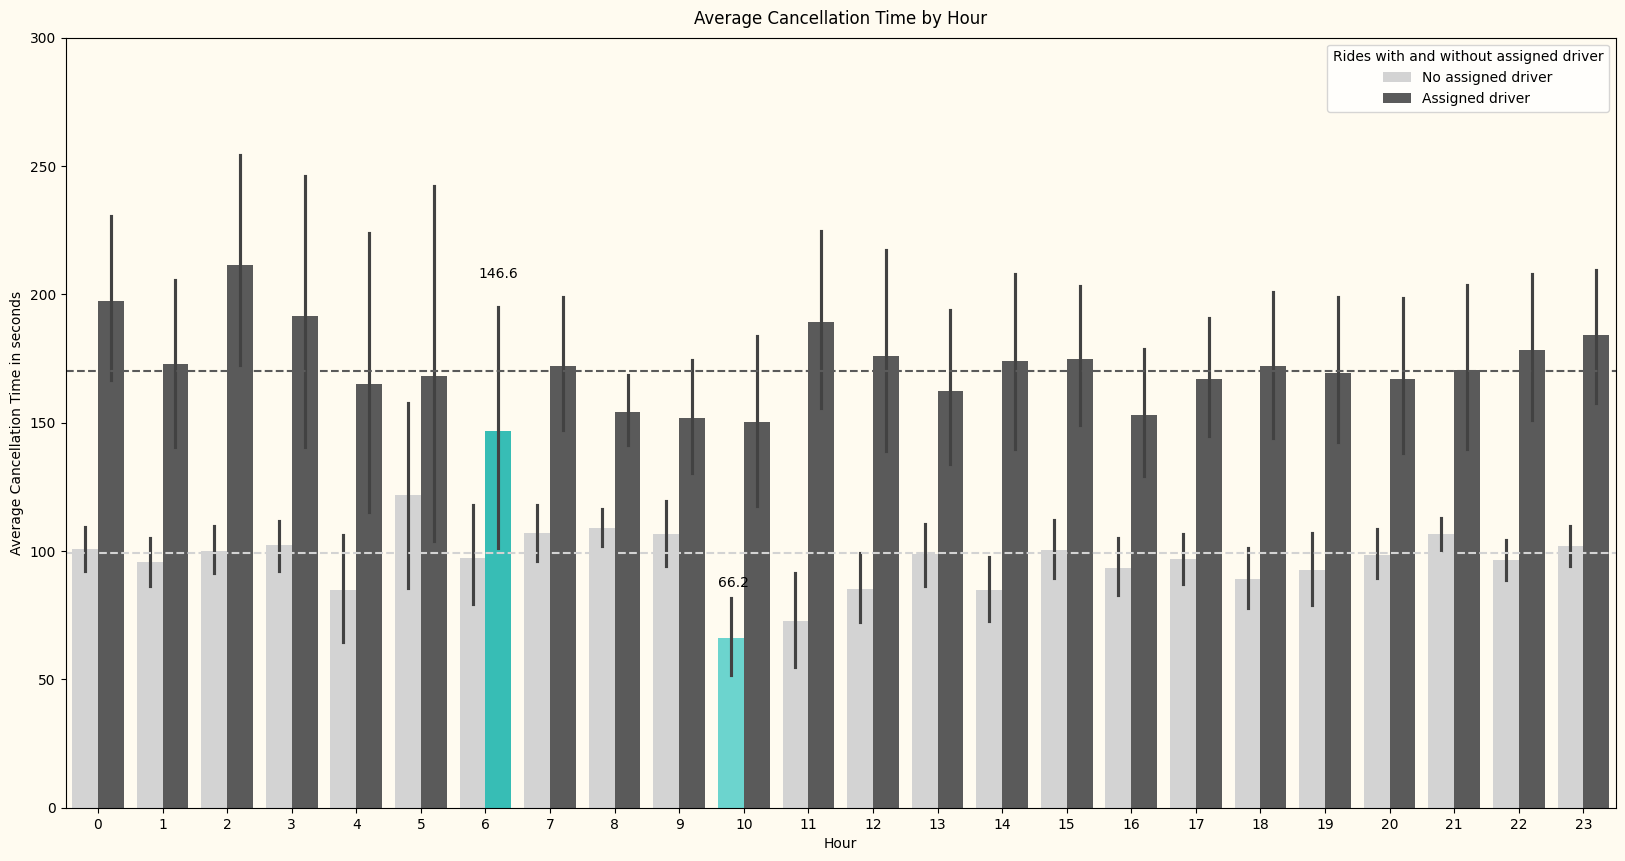

In [29]:
# Let's define the space in which we will draw our graph along with the title.
# As we only want to see 24 hours we set the limit of the x axis to 24, and for the y-axis we set the maximum limit to 300s.
# Lastly we rename the y-axis label to make it understandable that we are plotting the average cancellation time in seconds.

fig, ax1 = plt.subplots(1, 1, figsize=(20,10))

# plt.figure(figsize=(20,10))
plt.title('Average Cancellation Time by Hour', pad=10)
plt.xlim(-1,24)
plt.xticks(range(0,24))
plt.ylim(0,300)
plt.ylabel('Average Cancellation Time in seconds')



# We start by plotting the average cancellation time for cancelled orders by hours.
# Lastly to make our plot more readable we add a legend to it.

g = sns.barplot(data=df_user_cancelled_no_outlier, x='Hour', y='cancellations_time_in_seconds', hue='is_driver_assigned_key', palette=['#D3D3D3','#5A5A5A'])


# change legend texts
new_title = 'Rides with and without assigned driver'
g.legend_.set_title(new_title)
new_labels = ['No assigned driver', 'Assigned driver']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

# To add more context we'll add the overall average cancellation time to both rides with and without assigned driver.

plt.axhline(y = driver_assigned_df_wo_outlier['cancellations_time_in_seconds'].mean(), ls='--', color='#5A5A5A')
plt.axhline(y = no_driver_assigned_df_wo_outlier['cancellations_time_in_seconds'].mean(), ls='--', color='#D3D3D3')

# To highlight the hours where customers are the most 'impatient' and cancel orders faster we'll color the bars in another color and add their values to the graph.


heights = [p.get_height() for p in g.patches]

heights_without_assigned_driver = heights[:24].copy()

heights_assigned_driver = heights[24:48].copy()

heights_assigned_driver = np.asarray(heights_assigned_driver)
heights_without_assigned_driver = np.asarray(heights_without_assigned_driver)

for p in g.patches:
    if  p.get_height() == heights_without_assigned_driver.min():
        p.set_facecolor('#6cd4ce')
        plt.text(x=p.get_x(), y=p.get_height() + 20, s= '{:,.1f}'.format(p.get_height()))

for p in g.patches:
    if  p.get_height() == heights_assigned_driver.min():
        p.set_facecolor('#37BDB5')
        plt.text(x=p.get_x()+0.2, y=p.get_height() + 60, s= '{:,.1f}'.format(p.get_height()), ha='center')

# To change slightly the color of the background of the plot we change it to this warmer color

g.set_facecolor('#FFFBF0')
fig.set_facecolor('#FFFBF0')

plt.show();

We can see that rides that didn't have an assigned driver were always cancelled faster than rides with an assigned driver. 
Moreover, we can see that the time were users are cancelling fastest, for rides without an assigned driver, is at 10 am. In comparison rides with an assigned driver were cancelled fastest at 6 am.
Additionally, customers are waiting longer for rides without a driver at 5 am while customers with an assigned driver wait longer in the night (midnight, 2 and 3 am) as well as around 11 am. 
The average cancellation time for rides without a driver is 100s, while rides with a driver tend to be cancelled after 170s. 


### 5. Average ETA by hours

> **Recap of our previous findings**. 
<br>The column *m_order_eta* has 7,902 missing values due to the order not having an assigned driver. <br>Therefore, we will only use the dataframe *driver_assigned_df*.

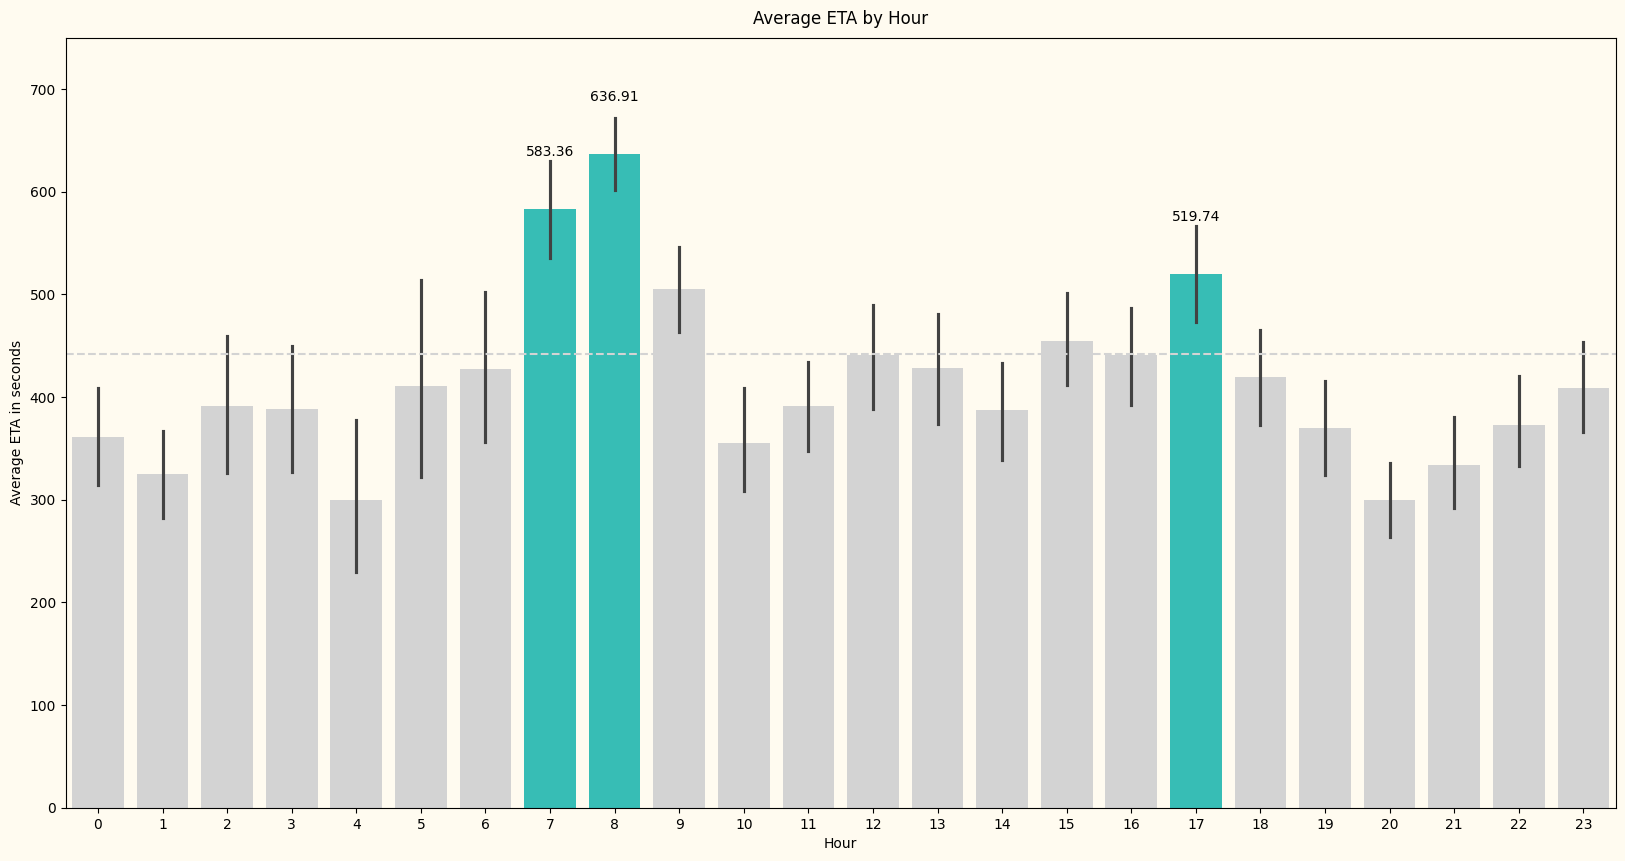

In [30]:
# Let's define the space in which we will draw our graph along with the title.
# As we only want to see 24 hours we set the limit of the x axis to 24, and for the y-axis we set the maximum limit to 750
# Lastly we rename the y-axis label to make it understandable that we are plotting the average estimated time of arrival (ETA).

fig, ax1 = plt.subplots(1, 1, figsize=(20,10))

# plt.figure(figsize=(20,10))
plt.title('Average ETA by Hour', pad=10)
plt.xlim(-1,24)
plt.xticks(range(0,24))
plt.ylim(0,750)
plt.ylabel('Average ETA in seconds')



# We start by plotting the average estimated time of arrival for cancelled orders by hours. 
# Note that we only use the filtered dataframe 'driver_assigned_df' as only rides with a assigned driver
# have a value for ETA.

g = sns.barplot(data=driver_assigned_df, x='Hour', y='m_order_eta', color='#D3D3D3')

# To have a comparison we add a line to show the overall average estimated time of arrival.

plt.axhline(y = driver_assigned_df['m_order_eta'].mean(), ls='--', color='#D3D3D3')

# Finally to highlight the hours that had the highest ETA we will color the top 3 hours in another color and display their average ETA value.

heights = [p.get_height() for p in g.patches]
third_highest = sorted(heights)[-3]

for p in g.patches:
     if  p.get_height() >= third_highest:
        p.set_facecolor('#37BDB5')
        plt.text(x=p.get_x()+0.4, y=p.get_height() + 52, s= '{:,.2f}'.format(p.get_height()), ha='center')

# To change slightly the color of the background of the plot we change it to this warmer color

g.set_facecolor('#FFFBF0')
fig.set_facecolor('#FFFBF0')

plt.show()

We can clearly see that from 7 to 8 am the cancelled rides had a longer ETA and at 5 pm we see another peak, which corresponds to the morning and evening traffic peaks.  
During these hours as the traffic clogs rides' ETA are longer. Moreover, we see that 8 am had the longest average ETA which corresponds also to the peak in cancelled orders.  
We can thus conclude that higher ETA's lead to higher cancellations.

### 6. Failed orders by Regions (Hexagons)
Using the h3 and folium packages, calculate how many hexes (resolution = 8) contain 80% of all orders from the original data sets  
and visualise the hexes, colouring them by the number of fails on the map.

In [31]:
# We first create a column in the df_orders dataframe by using the method of the h3 library 'geo_to_h3' which creates the hexagons id from the latitude and longitude columns, lastly we'll set the resolution of the hexagon grid to 8.

df_orders['h3_hex_id'] = df_orders.apply(lambda row: h3.geo_to_h3(row['origin_latitude'], row['origin_longitude'], 8), axis=1) 

# From there we can create a new dataframe counting how many times a hexagon appears in the order column.

hex_counts = df_orders['h3_hex_id'].value_counts().reset_index() 

# To make it easier to read we'll rename the columns to h3_hex_id and order_count.
hex_counts.columns = ['h3_hex_id', 'order_count']

Now that we have a dataframe that has both hexagon ids and the count of failed orders we'll need to understand how many hexagons contain 80% of the total failed orders.
To do this we'll create a new column in the hex_counts dataframe and use the cumsum method to calculate the cummulative sum of failed orders. 

In [32]:
hex_counts['Cummulative Sum'] = hex_counts['order_count'].cumsum()

hex_counts

,h3_hex_id,order_count,Cummulative Sum
0,88195d2b1dfffff,1497,1497
1,88195d2b1bfffff,870,2367
2,88195d2b15fffff,774,3141
3,88195d2b11fffff,707,3848
4,88195d2b19fffff,667,4515
...,...,...,...
139,88195d2821fffff,1,10712
140,88195d3993fffff,1,10713
141,88195d2b69fffff,1,10714
142,88195d74d5fffff,1,10715


Now that we have  the cummulative sum we can calculate the cummulative percentage and finally filter out the rows that are higher than 80%.

In [33]:
hex_counts['Cummulative Pct'] = hex_counts['Cummulative Sum'] / hex_counts['Cummulative Sum'].max()

filtered_hex_count = hex_counts[hex_counts['Cummulative Pct'] <= 0.8].copy()

filtered_hex_count

,h3_hex_id,order_count,Cummulative Sum,Cummulative Pct
0,88195d2b1dfffff,1497,1497,0.139698
1,88195d2b1bfffff,870,2367,0.220885
2,88195d2b15fffff,774,3141,0.293113
3,88195d2b11fffff,707,3848,0.359089
4,88195d2b19fffff,667,4515,0.421333
5,88195d284dfffff,653,5168,0.482270
6,88195d2a27fffff,414,5582,0.520903
7,88195d2b0bfffff,372,5954,0.555618
8,88195d2a25fffff,362,6316,0.589399
9,88195d2b13fffff,346,6662,0.621687


In [34]:
filtered_hex_count['hex boundary'] = filtered_hex_count.apply(lambda row: h3.h3_to_geo_boundary(row['h3_hex_id']), axis=1) 

filtered_hex_count


,h3_hex_id,order_count,Cummulative Sum,Cummulative Pct,hex boundary
0,88195d2b1dfffff,1497,1497,0.139698,"((51.46233424112636, -0.9674195894273825), (51..."
1,88195d2b1bfffff,870,2367,0.220885,"((51.45257385379414, -0.9507230105639873), (51..."
2,88195d2b15fffff,774,3141,0.293113,"((51.45658471409391, -0.9753174349705782), (51..."
3,88195d2b11fffff,707,3848,0.359089,"((51.454579842735626, -0.9630191652468901), (5..."
4,88195d2b19fffff,667,4515,0.421333,"((51.46032841933335, -0.9551211707321967), (51..."
5,88195d284dfffff,653,5168,0.482270,"((51.44481886728639, -0.9463261989134449), (51..."
6,88195d2a27fffff,414,5582,0.520903,"((51.4505667478549, -0.9384289715086821), (51...."
7,88195d2b0bfffff,372,5954,0.555618,"((51.470088217811636, -0.9718213633595971), (5..."
8,88195d2a25fffff,362,6316,0.589399,"((51.45832148008727, -0.9428248679734373), (51..."
9,88195d2b13fffff,346,6662,0.621687,"((51.4468250230316, -0.9586200902493034), (51...."


In [35]:
import shapely
import geopandas as gpd

In [36]:
for row in filtered_hex_count['hex boundary']:
    filtered_hex_count['geometry'] = shapely.geometry.Polygon(row)

In [37]:
print(type(filtered_hex_count))
filtered_hex_count



<class 'pandas.core.frame.DataFrame'>


,h3_hex_id,order_count,Cummulative Sum,Cummulative Pct,hex boundary,geometry
0,88195d2b1dfffff,1497,1497,0.139698,"((51.46233424112636, -0.9674195894273825), (51...",POLYGON ((51.47583628593767 -0.963921538896394...
1,88195d2b1bfffff,870,2367,0.220885,"((51.45257385379414, -0.9507230105639873), (51...",POLYGON ((51.47583628593767 -0.963921538896394...
2,88195d2b15fffff,774,3141,0.293113,"((51.45658471409391, -0.9753174349705782), (51...",POLYGON ((51.47583628593767 -0.963921538896394...
3,88195d2b11fffff,707,3848,0.359089,"((51.454579842735626, -0.9630191652468901), (5...",POLYGON ((51.47583628593767 -0.963921538896394...
4,88195d2b19fffff,667,4515,0.421333,"((51.46032841933335, -0.9551211707321967), (51...",POLYGON ((51.47583628593767 -0.963921538896394...
5,88195d284dfffff,653,5168,0.482270,"((51.44481886728639, -0.9463261989134449), (51...",POLYGON ((51.47583628593767 -0.963921538896394...
6,88195d2a27fffff,414,5582,0.520903,"((51.4505667478549, -0.9384289715086821), (51....",POLYGON ((51.47583628593767 -0.963921538896394...
7,88195d2b0bfffff,372,5954,0.555618,"((51.470088217811636, -0.9718213633595971), (5...",POLYGON ((51.47583628593767 -0.963921538896394...
8,88195d2a25fffff,362,6316,0.589399,"((51.45832148008727, -0.9428248679734373), (51...",POLYGON ((51.47583628593767 -0.963921538896394...
9,88195d2b13fffff,346,6662,0.621687,"((51.4468250230316, -0.9586200902493034), (51....",POLYGON ((51.47583628593767 -0.963921538896394...


In [76]:
geo_df = gpd.GeoDataFrame(filtered_hex_count, crs="EPSG:4326", geometry=filtered_hex_count['geometry'])

geo_df

,h3_hex_id,order_count,Cummulative Sum,Cummulative Pct,hex boundary,geometry
0,88195d2b1dfffff,1497,1497,0.139698,"((51.46233424112636, -0.9674195894273825), (51...","POLYGON ((51.47584 -0.96392, 51.47459 -0.97066..."
1,88195d2b1bfffff,870,2367,0.220885,"((51.45257385379414, -0.9507230105639873), (51...","POLYGON ((51.47584 -0.96392, 51.47459 -0.97066..."
2,88195d2b15fffff,774,3141,0.293113,"((51.45658471409391, -0.9753174349705782), (51...","POLYGON ((51.47584 -0.96392, 51.47459 -0.97066..."
3,88195d2b11fffff,707,3848,0.359089,"((51.454579842735626, -0.9630191652468901), (5...","POLYGON ((51.47584 -0.96392, 51.47459 -0.97066..."
4,88195d2b19fffff,667,4515,0.421333,"((51.46032841933335, -0.9551211707321967), (51...","POLYGON ((51.47584 -0.96392, 51.47459 -0.97066..."
5,88195d284dfffff,653,5168,0.482270,"((51.44481886728639, -0.9463261989134449), (51...","POLYGON ((51.47584 -0.96392, 51.47459 -0.97066..."
6,88195d2a27fffff,414,5582,0.520903,"((51.4505667478549, -0.9384289715086821), (51....","POLYGON ((51.47584 -0.96392, 51.47459 -0.97066..."
7,88195d2b0bfffff,372,5954,0.555618,"((51.470088217811636, -0.9718213633595971), (5...","POLYGON ((51.47584 -0.96392, 51.47459 -0.97066..."
8,88195d2a25fffff,362,6316,0.589399,"((51.45832148008727, -0.9428248679734373), (51...","POLYGON ((51.47584 -0.96392, 51.47459 -0.97066..."
9,88195d2b13fffff,346,6662,0.621687,"((51.4468250230316, -0.9586200902493034), (51....","POLYGON ((51.47584 -0.96392, 51.47459 -0.97066..."


In [39]:
test_json = geo_df.set_index('h3_hex_id')[['geometry', 'order_count']]

test_json

,geometry,order_count
h3_hex_id,,
88195d2b1dfffff,"POLYGON ((51.47584 -0.96392, 51.47459 -0.97066...",1497
88195d2b1bfffff,"POLYGON ((51.47584 -0.96392, 51.47459 -0.97066...",870
88195d2b15fffff,"POLYGON ((51.47584 -0.96392, 51.47459 -0.97066...",774
88195d2b11fffff,"POLYGON ((51.47584 -0.96392, 51.47459 -0.97066...",707
88195d2b19fffff,"POLYGON ((51.47584 -0.96392, 51.47459 -0.97066...",667
88195d284dfffff,"POLYGON ((51.47584 -0.96392, 51.47459 -0.97066...",653
88195d2a27fffff,"POLYGON ((51.47584 -0.96392, 51.47459 -0.97066...",414
88195d2b0bfffff,"POLYGON ((51.47584 -0.96392, 51.47459 -0.97066...",372
88195d2a25fffff,"POLYGON ((51.47584 -0.96392, 51.47459 -0.97066...",362


In [77]:
test_json = test_json.to_json()

test_json

AttributeError: 'str' object has no attribute 'to_json'

In [78]:
filtered_hex_count_dict = filtered_hex_count.set_index('h3_hex_id')['order_count']

print(type(filtered_hex_count_dict))

filtered_hex_count_dict

<class 'pandas.core.series.Series'>


h3_hex_id
88195d2b1dfffff    1497
88195d2b1bfffff     870
88195d2b15fffff     774
88195d2b11fffff     707
88195d2b19fffff     667
88195d284dfffff     653
88195d2a27fffff     414
88195d2b0bfffff     372
88195d2a25fffff     362
88195d2b13fffff     346
88195d2b03fffff     257
88195d2b17fffff     210
88195d2b39fffff     184
88195d2861fffff     182
88195d2a21fffff     156
88195d2b3dfffff     153
88195d2b31fffff     143
88195d2869fffff     125
88195d2b3bfffff     115
88195d2b51fffff      98
88195d2b57fffff      92
88195d2a23fffff      91
88195d2b55fffff      85
Name: order_count, dtype: int64

In [79]:
import branca.colormap as cm
linear = cm.LinearColormap(["#FFFBF0", "#37BDB5"], vmin=85, vmax=1497)

linear

In [80]:
test_map = folium.Map(location=(df_orders['origin_latitude'].mean(), df_orders['origin_longitude'].mean()), zoom_start=12.5, tiles="cartodbpositron")

folium.GeoJson(
    test_json,
    style_function=lambda feature: {
        "fillColor": linear(filtered_hex_count_dict[feature["id"]]),
        "color": "grey",
        "weight": 0.5,
    },
).add_to(test_map)

In [81]:
test_map

In [45]:
map_hex = folium.Map(location=(df_orders['origin_latitude'].mean(), df_orders['origin_longitude'].mean()), zoom_start=13.5, tiles="cartodbpositron")

map_hex

In [46]:
for row in filtered_hex_count['hex boundary']:
    folium.Polygon([row],
                   color='#D3D3D3',
                   weight=1,
                   line_color='#D3D3D3',
                   fill=True, 
                   fill_opacity=0.5,
                   fill_color='#37BDB5').add_to(map_hex)

In [47]:
map_hex

In [48]:
def get_hexagon_grid(latitude, longitude, resolution, ring_size):
    """
    Generate a hexagonal grid GeoDataFrame centered around a specified location.
    Parameters:
    - latitude (float): Latitude of the center point.
    - longitude (float): Longitude of the center point.
    - resolution (int): H3 resolution for hexagons.
    - ring_size (int): Number of rings to create around the center hexagon.
    Returns:
    - hexagon_df (geopandas.GeoDataFrame): GeoDataFrame containing hexagons and their geometries.
    """

    # Get the H3 hexagons covering the specified location
    center_h3 = h3.geo_to_h3(latitude, longitude, resolution)
    hexagons = list(h3.k_ring(center_h3, ring_size))  # Convert the set to a list

    # Create a GeoDataFrame with hexagons and their corresponding geometries
    hexagon_geometries = [shapely.geometry.Polygon(h3.h3_to_geo_boundary(hexagon, geo_json=True)) for hexagon in hexagons]
    hexagon_df = gpd.GeoDataFrame({'Hexagon_ID': hexagons, 'geometry': hexagon_geometries})

    return hexagon_df

In [49]:
failed_rides_lat = df_orders['origin_latitude'].mean()
failed_rides_lng = df_orders['origin_longitude'].mean()

resolution = 8
ring_size=5

hexagon_df = get_hexagon_grid(failed_rides_lat, failed_rides_lng,resolution, ring_size)

hexagon_df

,Hexagon_ID,geometry
0,88195d2b6bfffff,"POLYGON ((-0.99294 51.48760, -0.99967 51.48635..."
1,88195d2a61fffff,"POLYGON ((-0.91912 51.47556, -0.92586 51.47431..."
2,88195d2b63fffff,"POLYGON ((-1.00084 51.48185, -1.00757 51.48060..."
3,88195d280dfffff,"POLYGON ((-0.95772 51.42556, -0.96445 51.42431..."
4,88195d2845fffff,"POLYGON ((-0.95422 51.43907, -0.96095 51.43782..."
...,...,...
86,88195d2865fffff,"POLYGON ((-0.98671 51.43733, -0.99344 51.43608..."
87,88195d2a37fffff,"POLYGON ((-0.91735 51.43305, -0.92408 51.43180..."
88,88195d2a29fffff,"POLYGON ((-0.92263 51.46206, -0.92936 51.46081..."
89,88195d2b45fffff,"POLYGON ((-0.98503 51.49335, -0.99177 51.49210..."


In [82]:
merged_hex_df = hexagon_df.merge(filtered_hex_count, left_on ='Hexagon_ID', right_on = 'h3_hex_id', how='right')

print(merged_hex_df.isna().sum())

print(merged_hex_df.shape)
print(type(merged_hex_df))

# merged_hex_df.set_crs(epsg=4326, inplace=True)

Hexagon_ID         0
geometry_x         0
h3_hex_id          0
order_count        0
Cummulative Sum    0
Cummulative Pct    0
hex boundary       0
geometry_y         0
dtype: int64
(23, 8)
<class 'pandas.core.frame.DataFrame'>


In [83]:
merged_hex_df

,Hexagon_ID,geometry_x,h3_hex_id,order_count,Cummulative Sum,Cummulative Pct,hex boundary,geometry_y
0,88195d2b1dfffff,"POLYGON ((-0.96742 51.46233, -0.97415 51.46109...",88195d2b1dfffff,1497,1497,0.139698,"((51.46233424112636, -0.9674195894273825), (51...",POLYGON ((51.47583628593767 -0.963921538896394...
1,88195d2b1bfffff,"POLYGON ((-0.95072 51.45257, -0.95745 51.45133...",88195d2b1bfffff,870,2367,0.220885,"((51.45257385379414, -0.9507230105639873), (51...",POLYGON ((51.47583628593767 -0.963921538896394...
2,88195d2b15fffff,"POLYGON ((-0.97532 51.45658, -0.98205 51.45534...",88195d2b15fffff,774,3141,0.293113,"((51.45658471409391, -0.9753174349705782), (51...",POLYGON ((51.47583628593767 -0.963921538896394...
3,88195d2b11fffff,"POLYGON ((-0.96302 51.45458, -0.96975 51.45333...",88195d2b11fffff,707,3848,0.359089,"((51.454579842735626, -0.9630191652468901), (5...",POLYGON ((51.47583628593767 -0.963921538896394...
4,88195d2b19fffff,"POLYGON ((-0.95512 51.46033, -0.96185 51.45908...",88195d2b19fffff,667,4515,0.421333,"((51.46032841933335, -0.9551211707321967), (51...",POLYGON ((51.47583628593767 -0.963921538896394...
5,88195d284dfffff,"POLYGON ((-0.94633 51.44482, -0.95306 51.44357...",88195d284dfffff,653,5168,0.482270,"((51.44481886728639, -0.9463261989134449), (51...",POLYGON ((51.47583628593767 -0.963921538896394...
6,88195d2a27fffff,"POLYGON ((-0.93843 51.45057, -0.94516 51.44932...",88195d2a27fffff,414,5582,0.520903,"((51.4505667478549, -0.9384289715086821), (51....",POLYGON ((51.47583628593767 -0.963921538896394...
7,88195d2b0bfffff,"POLYGON ((-0.97182 51.47009, -0.97856 51.46884...",88195d2b0bfffff,372,5954,0.555618,"((51.470088217811636, -0.9718213633595971), (5...",POLYGON ((51.47583628593767 -0.963921538896394...
8,88195d2a25fffff,"POLYGON ((-0.94282 51.45832, -0.94956 51.45707...",88195d2a25fffff,362,6316,0.589399,"((51.45832148008727, -0.9428248679734373), (51...",POLYGON ((51.47583628593767 -0.963921538896394...
9,88195d2b13fffff,"POLYGON ((-0.95862 51.44683, -0.96535 51.44558...",88195d2b13fffff,346,6662,0.621687,"((51.4468250230316, -0.9586200902493034), (51....",POLYGON ((51.47583628593767 -0.963921538896394...


In [84]:
merged_hex_df_filtered = merged_hex_df[['Hexagon_ID', 'geometry_x', 'order_count']].copy()

merged_hex_df_filtered = merged_hex_df_filtered.dropna()

merged_hex_df_filtered.reset_index(inplace=True)

merged_hex_df_filtered

,index,Hexagon_ID,geometry_x,order_count
0,0,88195d2b1dfffff,"POLYGON ((-0.96742 51.46233, -0.97415 51.46109...",1497
1,1,88195d2b1bfffff,"POLYGON ((-0.95072 51.45257, -0.95745 51.45133...",870
2,2,88195d2b15fffff,"POLYGON ((-0.97532 51.45658, -0.98205 51.45534...",774
3,3,88195d2b11fffff,"POLYGON ((-0.96302 51.45458, -0.96975 51.45333...",707
4,4,88195d2b19fffff,"POLYGON ((-0.95512 51.46033, -0.96185 51.45908...",667
5,5,88195d284dfffff,"POLYGON ((-0.94633 51.44482, -0.95306 51.44357...",653
6,6,88195d2a27fffff,"POLYGON ((-0.93843 51.45057, -0.94516 51.44932...",414
7,7,88195d2b0bfffff,"POLYGON ((-0.97182 51.47009, -0.97856 51.46884...",372
8,8,88195d2a25fffff,"POLYGON ((-0.94282 51.45832, -0.94956 51.45707...",362
9,9,88195d2b13fffff,"POLYGON ((-0.95862 51.44683, -0.96535 51.44558...",346


In [85]:
print(type(merged_hex_df_filtered))
merged_gdf = gpd.GeoDataFrame(merged_hex_df_filtered, crs="EPSG:4326", geometry=merged_hex_df_filtered['geometry_x'])

merged_gdf = merged_gdf[['Hexagon_ID','geometry', 'order_count']]

print(type(merged_gdf))

<class 'pandas.core.frame.DataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>


In [86]:
merged_gdf

,Hexagon_ID,geometry,order_count
0,88195d2b1dfffff,"POLYGON ((-0.96742 51.46233, -0.97415 51.46109...",1497
1,88195d2b1bfffff,"POLYGON ((-0.95072 51.45257, -0.95745 51.45133...",870
2,88195d2b15fffff,"POLYGON ((-0.97532 51.45658, -0.98205 51.45534...",774
3,88195d2b11fffff,"POLYGON ((-0.96302 51.45458, -0.96975 51.45333...",707
4,88195d2b19fffff,"POLYGON ((-0.95512 51.46033, -0.96185 51.45908...",667
5,88195d284dfffff,"POLYGON ((-0.94633 51.44482, -0.95306 51.44357...",653
6,88195d2a27fffff,"POLYGON ((-0.93843 51.45057, -0.94516 51.44932...",414
7,88195d2b0bfffff,"POLYGON ((-0.97182 51.47009, -0.97856 51.46884...",372
8,88195d2a25fffff,"POLYGON ((-0.94282 51.45832, -0.94956 51.45707...",362
9,88195d2b13fffff,"POLYGON ((-0.95862 51.44683, -0.96535 51.44558...",346


In [87]:
geo_json_data = merged_gdf.to_json()

geo_json_data

'{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {"Hexagon_ID": "88195d2b1dfffff", "order_count": 1497}, "geometry": {"type": "Polygon", "coordinates": [[[-0.9674195894273825, 51.46233424112636], [-0.9741522492296825, 51.46108611918584], [-0.9753174349705782, 51.45658471409391], [-0.9697507654750529, 51.4533316919224], [-0.9630191652468901, 51.454579842735626], [-0.9618531750496696, 51.459080986831154], [-0.9674195894273825, 51.46233424112636]]]}}, {"id": "1", "type": "Feature", "properties": {"Hexagon_ID": "88195d2b1bfffff", "order_count": 870}, "geometry": {"type": "Polygon", "coordinates": [[[-0.9507230105639873, 51.45257385379414], [-0.957453955291134, 51.451326392230655], [-0.9586200902493034, 51.4468250230316], [-0.9530560843042358, 51.44357137656247], [-0.9463261989134449, 51.44481886728639], [-0.945159260240901, 51.449319975302565], [-0.9507230105639873, 51.45257385379414]]]}}, {"id": "2", "type": "Feature", "properties": {"Hexagon_ID": "

In [93]:
filtered_hex_count_dict

h3_hex_id
88195d2b1dfffff    1497
88195d2b1bfffff     870
88195d2b15fffff     774
88195d2b11fffff     707
88195d2b19fffff     667
88195d284dfffff     653
88195d2a27fffff     414
88195d2b0bfffff     372
88195d2a25fffff     362
88195d2b13fffff     346
88195d2b03fffff     257
88195d2b17fffff     210
88195d2b39fffff     184
88195d2861fffff     182
88195d2a21fffff     156
88195d2b3dfffff     153
88195d2b31fffff     143
88195d2869fffff     125
88195d2b3bfffff     115
88195d2b51fffff      98
88195d2b57fffff      92
88195d2a23fffff      91
88195d2b55fffff      85
Name: order_count, dtype: int64

In [94]:
filtered_hex_count_dict['88195d2b1dfffff']

1497

In [88]:
color_dict = {key: linear(filtered_hex_count_dict[key]) for key in filtered_hex_count_dict.keys()}

In [97]:
new_map = folium.Map(location=(df_orders['origin_latitude'].mean(), df_orders['origin_longitude'].mean()), zoom_start=13.5, tiles="cartodbpositron")

In [100]:
 folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        "fillColor": color_dict[feature["properties"]["Hexagon_ID"]],
        "color": "grey",
        "weight": 0.5,
        "fillOpacity":0.8,
    },
).add_to(new_map)

new_map

In [58]:
linear.caption = "Failed orders color scale"
linear.add_to(map_hex)

map_hex
